In [ ]:
import geopandas as gpd
import geemap
from outils.initializeGEE import initializeEarthEngine
from indexes.sentinel2IndexCalculator import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd

# Configure visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Initialize Google Earth Engine
initializeEarthEngine()

True

In [3]:
# Load indigenous territories data from parquet file
# Only the first 3 territories are selected for this example
gdf = gpd.read_parquet('data/terrasIndigenasBr.parquet')
gdf = gdf[:3]  # Using only 3 territories for demonstration/testing

# Convert GeoDataFrame to Earth Engine FeatureCollection
# This is necessary to use the geometries in Google Earth Engine
gdf_ee = geemap.geopandas_to_ee(gdf)

# Configuration parameters for satellite imagery analysis
start_date = '2022-01-01'
end_date = '2024-12-31'
batch_size = 10  # Number of features to process in each batch

# Create an instance of Sentinel2IndexCalculator
# This calculator will handle the retrieval and processing of Sentinel-2 imagery
calculator = Sentinel2IndexCalculator(
    start_date, 
    end_date, 
    gdf_ee,  
    id_column='terrai_cod',  # Column containing unique identifiers for each territory
    batch_size=batch_size    # Process features in batches to avoid memory issues
)

# Calculate NDVI (Normalized Difference Vegetation Index) for all territories
# NDVI is a measure of vegetation health and density
print(f"Calculating NDVI for {len(gdf)} territories from {start_date} to {end_date}...")
ndvi_df = calculator.calculate_single_index('ndvi')

# Display summary statistics of the resulting NDVI values
print(f"NDVI calculation complete. Results shape: {ndvi_df.shape}")
print("\nNDVI Summary Statistics:")
print(ndvi_df.describe())

# Save results to CSV (optional)
output_file = f"ndvi_results_{start_date.replace('-', '')}_{end_date.replace('-', '')}.csv"
ndvi_df.to_csv(output_file)
print(f"Results saved to {output_file}")

Calculating NDVI for 3 territories from 2022-01-01 to 2024-12-31...


Processing NDVI: 100%|██████████| 132/132 [06:36<00:00,  3.01s/it]

NDVI calculation complete. Results shape: (3954, 3)

NDVI Summary Statistics:
        terrai_cod         ndvi
count  3954.000000  1293.000000
mean    301.000000     0.281969
std     216.052012     0.221811
min     101.000000    -0.273592
25%     101.000000     0.089480
50%     201.000000     0.271693
75%     601.000000     0.424765
max     601.000000     0.875951
Results saved to ndvi_results_20220101_20241231.csv


### Time series visualization of raw NDVI from Sentinel-2 data

Preparing NDVI time series visualization...
Visualization saved to ndvi_visualization_20220101_20241231.png


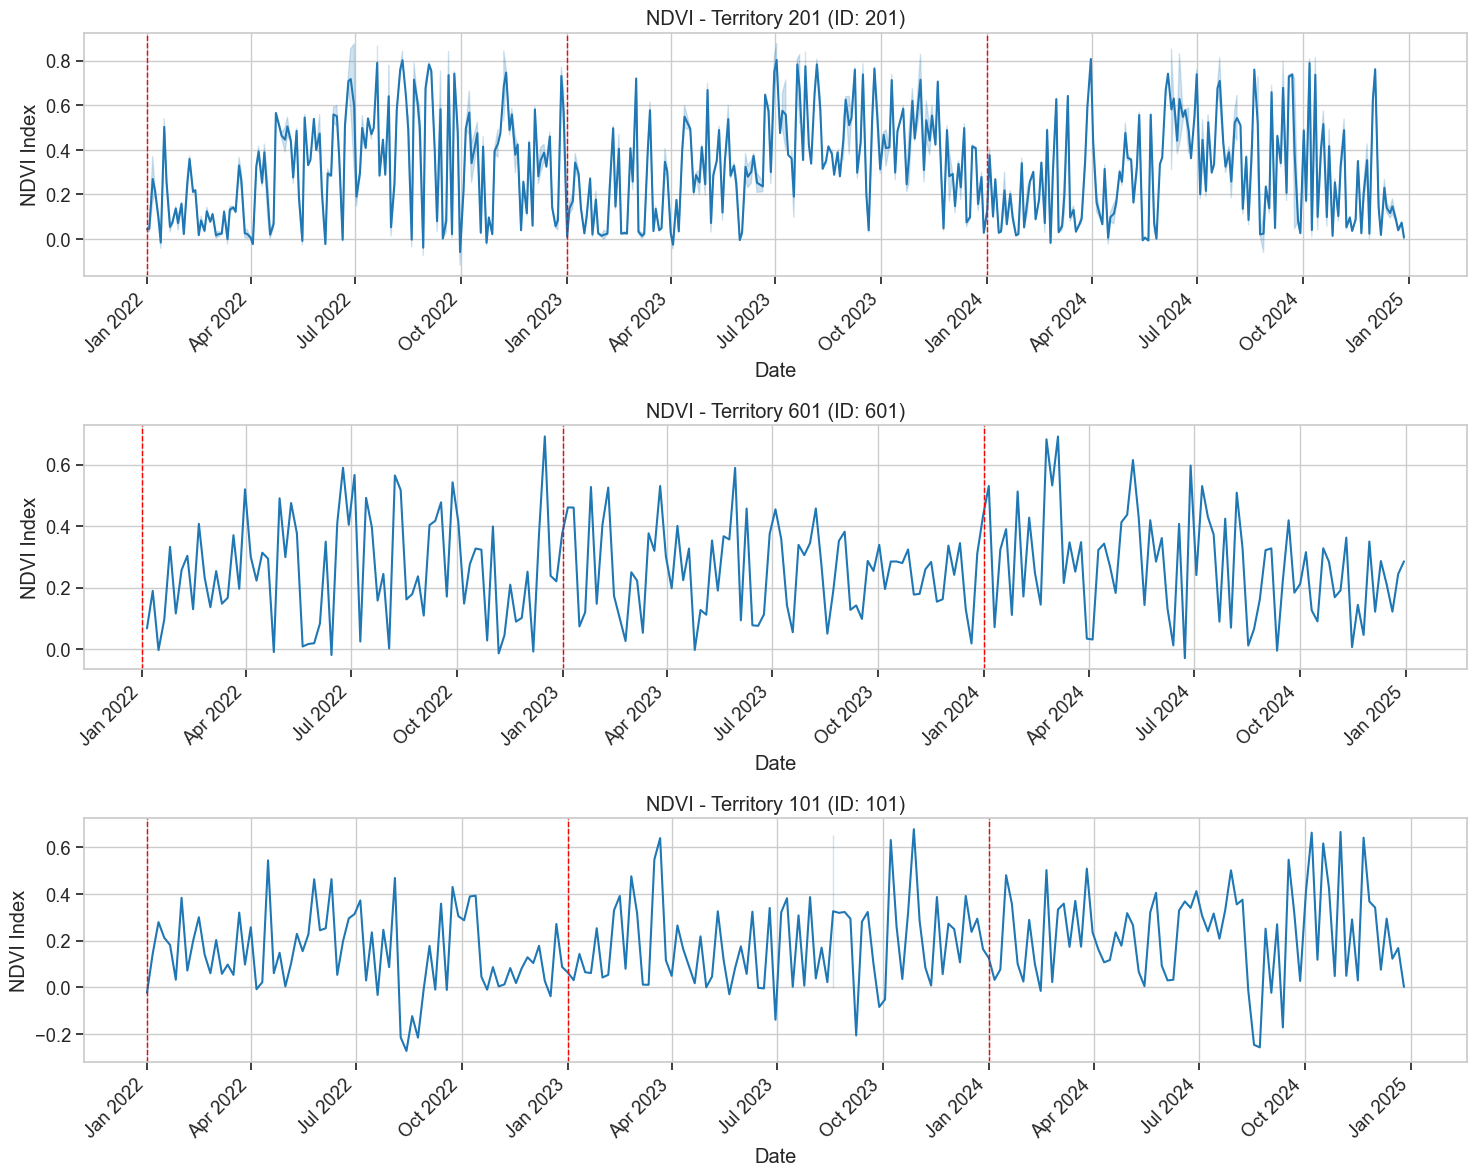

In [ ]:
# Time series visualization of vegetation indices from Sentinel-2 data

# Step 1: Convert date column to datetime format with correct format recognition
# The dates are in 'dd-mm-yyyy' format, so we use dayfirst=True
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'], dayfirst=True)

# Step 2: Select random territories to visualize (5 samples or fewer if there are less territories)
unique_territories = ndvi_df['terrai_cod'].unique()
territories_to_plot = np.random.choice(
    unique_territories, 
    min(5, len(unique_territories)), 
    replace=False
)

# Step 3: Create a multi-panel figure, one panel per territory
fig, axes = plt.subplots(
    len(territories_to_plot), 
    1, 
    figsize=(15, 4*len(territories_to_plot))
)

# Handle the case where there's only one territory (axes would be a single object, not a list)
if len(territories_to_plot) == 1:
    axes = [axes]

# Step 4: Plot NDVI time series for each selected territory
for i, territory_id in enumerate(territories_to_plot):
    # Filter data for the current territory
    territory_data = ndvi_df[ndvi_df['terrai_cod'] == territory_id].copy()
    
    # Sort data by date to ensure proper time series plotting
    territory_data = territory_data.sort_values('date')
    
    # Plot the NDVI values
    sns.lineplot(
        x='date', 
        y='ndvi', 
        data=territory_data, 
        ax=axes[i],
        linewidth=1.5
    )
    
    # Get territory name if available, otherwise use ID
    territory_name = territory_data.iloc[0].get('name', f'Territory {territory_id}')
    
    # Add title and labels
    axes[i].set_title(f'NDVI - {territory_name} (ID: {territory_id})')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('NDVI Index')
    
    # Format x-axis to show dates every three months
    axes[i].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add vertical red lines at the beginning of each year to highlight seasonality
    # Get the minimum and maximum years in the data
    min_year = territory_data['date'].dt.year.min()
    max_year = territory_data['date'].dt.year.max()
    
    # Draw a vertical line at the start of each year
    for year in range(min_year, max_year + 1):
        year_start_date = pd.to_datetime(f'{year}-01-01')
        # Check if the year date is within our data range
        if (year_start_date >= territory_data['date'].min()) and (year_start_date <= territory_data['date'].max()):
            axes[i].axvline(
                year_start_date, 
                color='red',       # Red line
                linestyle='--',    # Dashed line
                linewidth=1        # Line width
            )

# Adjust spacing between subplots to prevent overlap
plt.tight_layout()

# Save the visualization as a high-resolution image
file_name = f"ndvi_visualization_{start_date.replace('-', '')}_{end_date.replace('-', '')}.png"
fig.savefig(file_name, dpi=300, bbox_inches='tight')
print(f"Visualization saved to {file_name}")

# Display the plots
plt.show()